## Set up

Install required packages and load relevant data. Ensure you adjust to add relevant classifiers.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from joblib import dump
import pickle as pkl
## import required classifiers, preprocessing, etc.
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
# Add additional as required


# import custom files
from src.data import make_dataset
from src.data import submit_predictions
from src.visualization import visualize
#import misc visualisation and EDA packages
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns

### Set Directory paths

In [2]:
project_dir = Path.cwd().parent
report_dir = project_dir / 'reports'
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

## Download and Prepare Data

The `make_dataset.download_data` function retrieves the data directly from the kaggle API, unzips the files and saves them into the raw data directory.

In [3]:
competition = 'uts-advdsi-nba-career-prediction'
make_dataset.download_data(competition=competition,
                           path=raw_data_dir,
                           unzip=True)

In [4]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')


In [5]:
X_test = pd.read_csv(raw_data_dir / 'test.csv')

In [6]:
df_train.drop(columns=['Id_old', 'Id'], inplace=True)
X_test.drop(columns=['Id_old'], inplace=True)
test_id = X_test.pop('Id')

## Split into Training and Validation Set

In [7]:
target = 'TARGET_5Yrs'
X, y = make_dataset.separate_target(df_train, target=target)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

## Modelling

For this experiment, I will be ensembling a linear model and a random forest classifier using the `VotingClassifier` method. I have trained two examples of models to show the difference between using these models individually and the voting classifier.

## Linear Regression

In [8]:
lr_pipe = Pipeline([ ('scaler', StandardScaler()),
                 ('pca', PCA()),
        ('classifier',   LogisticRegression(max_iter = 10000))])
                    
lr_pipe.fit(X_train,y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('classifier', LogisticRegression(max_iter=10000))])

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  44 1024]
 [  28 5304]]
Accuracy:  0.835625
AUC:  0.7049704841940823
              precision    recall  f1-score   support

           0       0.61      0.04      0.08      1068
           1       0.84      0.99      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.72      0.52      0.49      6400
weighted avg       0.80      0.84      0.77      6400



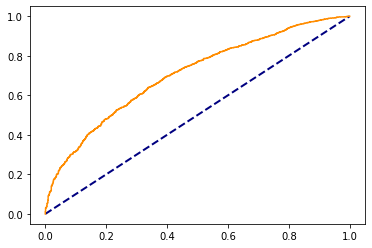

In [9]:
visualize.classification_reports(lr_pipe,X_train,y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   6  257]
 [   6 1331]]
Accuracy:  0.835625
AUC:  0.7172319846657433
              precision    recall  f1-score   support

           0       0.50      0.02      0.04       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.67      0.51      0.48      1600
weighted avg       0.78      0.84      0.77      1600



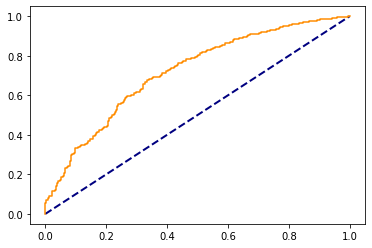

In [10]:
visualize.classification_reports(lr_pipe,X_val,y_val)

The linear regression appears to be failing to predict the minority class and biasing the majority class.

## Random Forest

In [11]:
rf_pipe = Pipeline([
        ('classifier', RandomForestClassifier(oob_score = True, n_estimators = 1000, max_depth = 3,max_features = 'log2',class_weight = 'balanced'))

])
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        max_features='log2', n_estimators=1000,
                                        oob_score=True))])

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[ 730  338]
 [2004 3328]]
Accuracy:  0.6340625
AUC:  0.7099524178797507
              precision    recall  f1-score   support

           0       0.27      0.68      0.38      1068
           1       0.91      0.62      0.74      5332

    accuracy                           0.63      6400
   macro avg       0.59      0.65      0.56      6400
weighted avg       0.80      0.63      0.68      6400



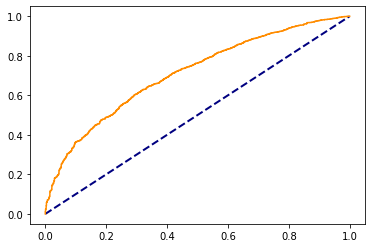

In [12]:
visualize.classification_reports(rf_pipe,X_train,y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[182  81]
 [502 835]]
Accuracy:  0.635625
AUC:  0.7116096134868655
              precision    recall  f1-score   support

           0       0.27      0.69      0.38       263
           1       0.91      0.62      0.74      1337

    accuracy                           0.64      1600
   macro avg       0.59      0.66      0.56      1600
weighted avg       0.81      0.64      0.68      1600



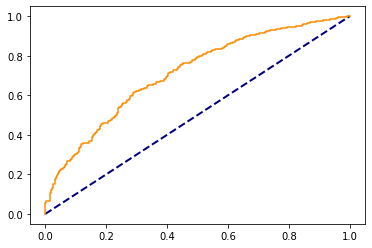

In [13]:
visualize.classification_reports(rf_pipe,X_val,y_val)

the random forest has a lower AUC and accuracy but is less biased towards the majority class.

## Create Voting Classifier

The voting classifier has some basic hyper parameter tuning of the voting weights of the two models for ensembling, the max depth, n_estimators, and max_features of the random forest, and the penalty for the linear regression model. 

In [14]:
rf_pipe = Pipeline([
        ('classifier', RandomForestClassifier(oob_score = True))
])


lr_pipe = Pipeline([ ('scaler', StandardScaler()),
                 ('pca', PCA()),
        ('classifier',   LogisticRegression(max_iter = 10000))
])


voter = VotingClassifier(estimators = [('rf',rf_pipe),('lr',lr_pipe)], voting = 'soft')

param_dist = {
    'weights': [[2,1],[1,1],[1,2], [1,3],[1,4]],
    'lr__classifier__penalty': ['l2'],
    'rf__classifier__n_estimators': [1000],
    'rf__classifier__max_depth': [3,4,5],
    'rf__classifier__max_features': ['log2', None],
    'rf__classifier__class_weight': ['balanced']
}

cv = RandomizedSearchCV(
    estimator=voter,
    param_distributions=param_dist,
    random_state=1,
    n_iter=12,
    cv=7,
    n_jobs=-1,
    verbose=10
)




In [15]:
cv.fit(X_train,y_train)

Fitting 7 folds for each of 12 candidates, totalling 84 fits


RandomizedSearchCV(cv=7,
                   estimator=VotingClassifier(estimators=[('rf',
                                                           Pipeline(steps=[('classifier',
                                                                            RandomForestClassifier(oob_score=True))])),
                                                          ('lr',
                                                           Pipeline(steps=[('scaler',
                                                                            StandardScaler()),
                                                                           ('pca',
                                                                            PCA()),
                                                                           ('classifier',
                                                                            LogisticRegression(max_iter=10000))]))],
                                              voting='soft'),
                  

In [16]:
cv.best_params_

{'weights': [1, 3],
 'rf__classifier__n_estimators': 1000,
 'rf__classifier__max_features': 'log2',
 'rf__classifier__max_depth': 3,
 'rf__classifier__class_weight': 'balanced',
 'lr__classifier__penalty': 'l2'}

### Inspect Results

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  81  987]
 [  67 5265]]
Accuracy:  0.8353125
AUC:  0.7104792349772837
              precision    recall  f1-score   support

           0       0.55      0.08      0.13      1068
           1       0.84      0.99      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.69      0.53      0.52      6400
weighted avg       0.79      0.84      0.78      6400



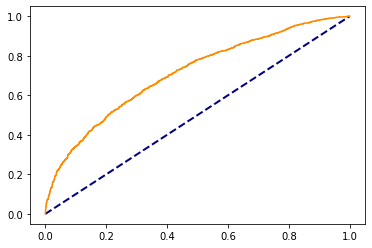

In [17]:
visualize.classification_reports(cv,X_train,y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[  18  245]
 [  18 1319]]
Accuracy:  0.835625
AUC:  0.7198313004257304
              precision    recall  f1-score   support

           0       0.50      0.07      0.12       263
           1       0.84      0.99      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.67      0.53      0.51      1600
weighted avg       0.79      0.84      0.78      1600



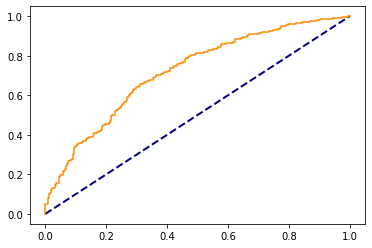

In [18]:
visualize.classification_reports(cv,X_val,y_val)

## Submit Predictions

In [19]:
submit_predictions.submit_predictions(cv, X_test, test_id,"12964298 week 1 submission - rf/lr voting",pred_path=processed_data_dir/'12964298_week1_voting_classifier.csv')

Success! User is Authenticated


100%|██████████| 87.6k/87.6k [00:05<00:00, 15.6kB/s]


,id,TARGET_5Yrs
0,0,0.735729
1,1,0.719266
2,2,0.876441
3,3,0.898882
4,4,0.673962
...,...,...
3794,3794,0.890799
3795,3795,0.760107
3796,3796,0.651439
3797,3797,0.898095


## Save Model File

In [20]:
file_name = models_dir /'brackenrig_mark_12964298_week1_votingclassifier.sav'
pkl.dump(cv, open(file_name, 'wb'))